# 1. Preparação do notebook

In [6]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import warnings
import matplotlib.pyplot as plt

In [7]:
# Oculta avisos específicos do NumPy
warnings.filterwarnings("ignore", category=UserWarning, module="numpy")

# 2. Leitura dos dados

In [8]:
# Abertura da caixa de diálogo para selecionar o arquivo
uploaded = files.upload()

# Obtenção do nome do arquivo selecionado
filename = list(uploaded.keys())[0]

# Leitura do arquivo para um DataFrame
df = pd.read_excel(filename)

df.head()

Saving [BM Regime Switching 1] Séries temporais.xlsx to [BM Regime Switching 1] Séries temporais.xlsx


,regime_switching_1_W,regime_switching_1_MA,regime_switching_1_KS,regime_switching_1_SES,regime_switching_1_QES,regime_switching_1_SPLINES,regime_switching_1_LOWESS,regime_switching_1_RF,regime_switching_1_HP,regime_switching_1_KALMAN
0,-1.687820,NaN,-1.695993,-1.687820,-1.229467,-1.687820,-17.722733,-1.687820,-7.956186,-1.687820
1,-1.229467,NaN,-1.205108,-1.687820,-0.922370,-1.229468,-17.582797,-1.550314,-7.927457,-1.412808
2,-0.830905,NaN,-0.587787,-1.550314,-0.579109,-0.830903,-17.442699,-1.334491,-7.898728,-1.054714
3,0.664868,NaN,-0.129334,-1.334491,-0.226812,0.664865,-17.302440,-0.734684,-7.869997,0.007381
4,-0.226449,-0.661955,-0.349115,-0.734684,0.495278,-0.226446,-17.162018,-0.582213,-7.841263,-0.137121


# 3. Previsão da série temporal

## 3.1. Criação de janelas deslizantes

In [9]:
# Função para criar janelas deslizantes
def create_sliding_windows(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

In [10]:
# Seleção da série
series = df['regime_switching_1_HP'].values

# Criação da janela deslizante
window_size = 1
X, y = create_sliding_windows(series, window_size)

In [11]:
X

array([[  -7.95618609],
       [  -7.9274571 ],
       [  -7.89872764],
       ...,
       [-596.09753079],
       [-595.56600647],
       [-595.5974935 ]])

In [12]:
y

array([  -7.9274571 ,   -7.89872764,   -7.86999674, ..., -595.56600647,
       -595.5974935 , -594.13785985])

## 3.2. Normalização

In [13]:
# Função para normalização Min-Max
def normalize_series(series):
    scaler = RobustScaler()
    series_scaled = scaler.fit_transform(series.reshape(-1, 1)).flatten()
    return series_scaled, scaler

In [14]:
# Normalização dos dados
X_scaled, scaler_X = normalize_series(X.flatten())
y_scaled, scaler_y = normalize_series(y)

X_scaled = X_scaled.reshape(-1, window_size)

## 3.2. Treinamento do modelo

In [15]:
# Função para treinar SVM com otimização reduzida de hiperparâmetros
def train_svm(X_train, y_train):
    param_grid = {
        'kernel': ['rbf', 'linear', 'sigmoid'],
        'C': [1, 10, 100],  # Parâmetro de custo
        'epsilon': [0.01, 0.1, 1]  # Margem de erro aceitável
    }

    model = GridSearchCV(SVR(), param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)  # Reduzindo validação cruzada para cv=3
    model.fit(X_train, y_train)
    return model.best_estimator_

In [16]:
# Divisão entre treino e teste (70% treino, 30% teste)
split_idx = int(0.7 * len(X_scaled))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

# Treinamento do modelo ELM
svm_model = train_svm(X_train, y_train)

## 3.3. Avaliação do modelo

In [17]:
# Previsões no conjunto de treino
y_train_pred_scaled = svm_model.predict(X_train).flatten()
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()

# Previsões no conjunto de teste
y_test_pred_scaled = svm_model.predict(X_test).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# DataFrames com previsões
train_results = pd.DataFrame({'Actual': scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten(),
                              'Predicted': y_train_pred})

test_results = pd.DataFrame({'Actual': scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten(),
                             'Predicted': y_test_pred})

In [18]:
# Cálculo do sMAPE
def smape(actual, predicted):
    return 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

smape_train = smape(train_results['Actual'].values, train_results['Predicted'].values).round(2)
smape_test = smape(test_results['Actual'].values, test_results['Predicted'].values).round(2)

print(f'sMAPE Treino: {smape_train:.2f}%')
print(f'sMAPE Teste: {smape_test:.2f}%')

sMAPE Treino: 3.64%
sMAPE Teste: 21.21%


In [19]:
# Cálculo do RMSE
def rmse(actual, predicted):
    return np.sqrt(np.mean((predicted - actual) ** 2))

rmse_train = rmse(train_results['Actual'].values, train_results['Predicted'].values)
rmse_test = rmse(test_results['Actual'].values, test_results['Predicted'].values)

print(f'RMSE Treino: {rmse_train:.2f}')
print(f'RMSE Teste: {rmse_test:.2f}')

RMSE Treino: 0.53
RMSE Teste: 169.42


In [20]:
# Cálculo do Huber Loss
def huber_loss(actual, predicted, delta=1.0):
    error = predicted - actual
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * error ** 2
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.mean(np.where(is_small_error, squared_loss, linear_loss))

huber_loss_train = huber_loss(train_results['Actual'].values, train_results['Predicted'].values)
huber_loss_test = huber_loss(test_results['Actual'].values, test_results['Predicted'].values)

print(f'Huber Loss Treino: {huber_loss_train:.2f}')
print(f'Huber Loss Teste: {huber_loss_test:.2f}')

Huber Loss Treino: 0.14
Huber Loss Teste: 56.63


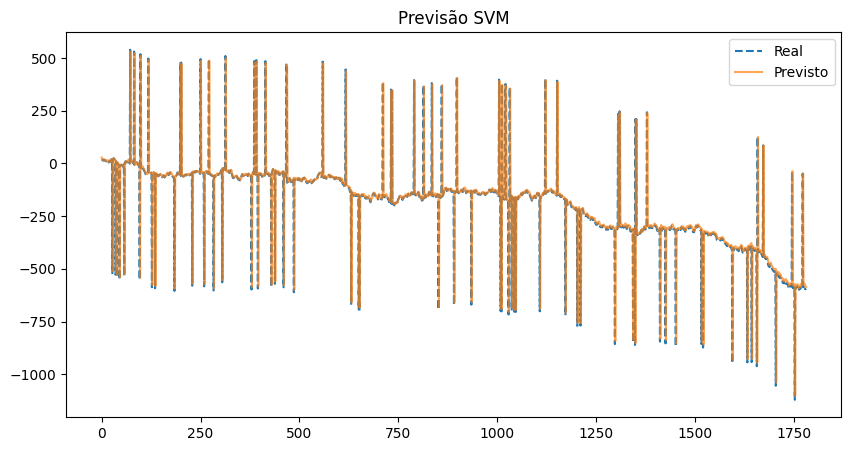

In [21]:
# Gráfico Real x Previsto
plt.figure(figsize=(10, 5))
plt.plot(test_results['Actual'], label='Real', linestyle='dashed')
plt.plot(test_results['Predicted'], label='Previsto', alpha=0.7)
plt.legend()
plt.title(f'Previsão SVM')
plt.show()

# 4. Análise dos erros

In [22]:
results = pd.concat([train_results, test_results])
results['Error'] = results['Actual'] - results['Predicted']

Q1 = results['Actual'].quantile(0.25)
Q3 = results['Actual'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = results[(results['Actual'] < lower_bound) | (results['Actual'] > upper_bound)]
outliers

,Actual,Predicted,Error
27,-520.361797,17.925821,-538.287618
35,-526.818923,12.001564,-538.820488
38,-537.322901,6.307558,-543.630459
45,-550.366396,-8.311734,-542.054662
57,-533.605739,-0.246885,-533.358854
...,...,...,...
1778,-588.370328,-569.871987,-18.498341
1779,-596.097531,-578.335543,-17.761988
1780,-595.566006,-585.941927,-9.624079
1781,-595.597494,-585.418714,-10.178780


In [23]:
# Identifica os outliers
results['Outlier'] = (results['Actual'] < lower_bound) | (results['Actual'] > upper_bound)
results.head()

,Actual,Predicted,Error,Outlier
0,-7.927457,-6.996450,-0.931007,False
1,-7.898728,-6.968170,-0.930557,False
2,-7.869997,-6.939890,-0.930107,False
3,-7.841263,-6.911608,-0.929654,False
4,-7.812524,-6.883324,-0.929200,False


In [24]:
# Teste de Mann-Whitney
from scipy.stats import mannwhitneyu

# Separa os erros dos dois grupos
erros_outliers = results[results['Outlier']]['Error']
erros_normais = results[~results['Outlier']]['Error']

# Aplicação do teste de Mann-Whitney
stat, p = mannwhitneyu(erros_outliers, erros_normais, alternative='greater')

# Exibir resultados
print(f"Estatística U: {stat}")
print(f"Valor-p: {p}")

if p < 0.05:
    print("Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.")
else:
    print("Não há evidência suficiente para afirmar que os outliers causam maiores erros.")

Estatística U: 609757.0
Valor-p: 1.0
Não há evidência suficiente para afirmar que os outliers causam maiores erros.


In [25]:
# Teste de Kruskal-Wallis
from scipy.stats import kruskal

# Classificação dos pontos
results['Grupo'] = 'normal'
results.loc[results['Actual'] < lower_bound, 'Grupo'] = 'outlier_negativo'
results.loc[results['Actual'] > upper_bound, 'Grupo'] = 'outlier_positivo'

# Separa os erros por grupo
erros_normais = results[results['Grupo'] == 'normal']['Error']
erros_outliers_neg = results[results['Grupo'] == 'outlier_negativo']['Error']
erros_outliers_pos = results[results['Grupo'] == 'outlier_positivo']['Error']

# Aplicação do teste de Kruskal-Wallis
stat, p = kruskal(erros_normais, erros_outliers_neg, erros_outliers_pos)

# Exibir resultados
print(f"Estatística U: {stat}")
print(f"Valor-p: {p}")

if p < 0.05:
    print("Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.")
else:
    print("Não há evidência suficiente para afirmar que os outliers causam maiores erros.")

Estatística U: 928.0215441562723
Valor-p: 3.0386602366899336e-202
Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.


In [26]:
# Análise da correlação de Spearman
from scipy.stats import spearmanr

# Calcular a correlação de Spearman
correlacao, p_valor = spearmanr(results['Outlier'], results['Error'])

# Exibir resultados
print(f"Correlação: {correlacao}")
print(f"Valor-p: {p_valor}")

if p_valor < 0.05:
    print("Existe uma relação significativa entre outliers e a magnitude do erro.")
else:
    print("Não há evidência estatística de que os outliers impactam significativamente os erros.")

Correlação: -0.3389265261391295
Valor-p: 1.2405022542356717e-159
Existe uma relação significativa entre outliers e a magnitude do erro.
